In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import comb
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA as SklearnPCA

In [2]:
# Function to center data by subtracting the mean
def center_data(X):
    # Calculate the mean of each feature (column)
    mean = np.mean(X, axis=0)
    # Subtract the mean to center the data around the origin
    X_centered = X - mean
    # Return centered data and mean
    return X_centered, mean

In [3]:
# Function to standardize data to Z-score, used in part 2 for standardization, not used when comparing with SklearnPCA
def standardize(X):
    # Calculate the mean of each feature
    mean = np.mean(X, axis=0)
    # Calculate the standard deviation of each feature
    std = np.std(X, axis=0)
    # Replace standard deviation with a small value (1e-9) if zero to avoid division by zero
    std_safe = np.where(std == 0, 1e-9, std)
    # Standardize data: (X - mean) / std
    X_std = (X - mean) / std_safe
    # Return standardized data, mean, and safe standard deviation
    return X_std, mean, std_safe

In [4]:
# Custom PCA implementation class
class MyPCA:
    def __init__(self, n_components):
        # Initialize PCA with the number of principal components
        # Check if n_components is a positive integer
        if not isinstance(n_components, int) or n_components <= 0:
            raise ValueError("n_components must be a positive integer.")
        # Store the number of principal components
        self.n_components = n_components
        # Initialize attributes to be computed during fit
        self.components_ = None  # Principal components matrix
        self.mean_ = None  # Mean of the data
        self.explained_variance_ = None  # Variance of principal components
        self.explained_variance_ratio_ = None  # Explained variance ratio
        self.cumulative_explained_variance_ratio_ = None  # Cumulative explained variance ratio

    def fit(self, X):
        # Train PCA model on data X
        # Center the data using center_data function
        X_processed, self.mean_ = center_data(X)
        # Get number of samples and features
        n_samples, n_features = X_processed.shape
        # Adjust n_components if it exceeds the number of features
        if self.n_components > n_features:
            self.n_components = n_features
        # Set n_components to at least 1 if valid
        if self.n_components == 0 and n_features > 0:
            self.n_components = 1
        elif n_features == 0:
            raise ValueError("Input data has no features.")
        # Perform SVD decomposition to compute eigenvalues and eigenvectors
        U, S, Vt = np.linalg.svd(X_processed, full_matrices=False)
        # Compute eigenvalues (variance) from S
        eig_val = (S ** 2) / (n_samples - 1)
        # Get eigenvectors from Vt
        eig_vec = Vt.T
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eig_val)[::-1]
        eig_val = eig_val[idx]
        eig_vec = eig_vec[:, idx]
        # Store principal components (corresponding eigenvectors)
        self.components_ = eig_vec[:, :self.n_components]
        # Store variance of principal components
        self.explained_variance_ = eig_val[:self.n_components]
        # Calculate total variance
        total_var = np.sum(eig_val)
        # Calculate explained variance ratio
        if total_var <= 1e-9:
            self.explained_variance_ratio_ = np.zeros(self.n_components)
        else:
            self.explained_variance_ratio_ = self.explained_variance_ / total_var
        # Calculate cumulative explained variance ratio
        self.cumulative_explained_variance_ratio_ = np.cumsum(self.explained_variance_ratio_)
        return self

    def transform(self, X):
        # Transform data to principal component space
        # Check if PCA has been trained
        if self.components_ is None or self.mean_ is None:
            raise RuntimeError("PCA has not been trained.")
        # Check if number of features in X matches training data
        if X.shape[1] != self.mean_.shape[0]:
            raise ValueError(f"Number of features in X ({X.shape[1]}) does not match training data ({self.mean_.shape[0]}).")
        # Center the data
        X_processed = X - self.mean_
        # Project data onto principal components
        return X_processed @ self.components_

In [5]:
# Load Iris dataset
iris = load_iris()
X_iris = iris['data']
y_iris = iris['target']
feature_names = iris['feature_names']

In [6]:
# Print dataset information
print("Iris dataset information:")
print(f"Number of rows: {X_iris.shape[0]}")
print(f"Number of columns: {X_iris.shape[1]}")
print(f"Column names: {feature_names}")

Iris dataset information:
Number of rows: 150
Number of columns: 4
Column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [7]:
# Apply MyPCA
n_components = 2
my_pca = MyPCA(n_components=n_components)
my_pca.fit(X_iris)
X_transformed_my = my_pca.transform(X_iris)

In [8]:
# Print EVR and CEVR
print("\nMyPCA Results:")
print(f"Explained Variance Ratio (EVR): {my_pca.explained_variance_ratio_}")
print(f"Cumulative Explained Variance Ratio (CEVR): {my_pca.cumulative_explained_variance_ratio_}")


MyPCA Results:
Explained Variance Ratio (EVR): [0.92461872 0.05306648]
Cumulative Explained Variance Ratio (CEVR): [0.92461872 0.97768521]


In [9]:
# Validate with scikit-learn PCA
sklearn_pca = SklearnPCA(n_components=n_components)
sklearn_pca.fit(X_iris)
X_transformed_sklearn = sklearn_pca.transform(X_iris)

print("\nScikit-learn PCA Results:")
print(f"Explained Variance Ratio (EVR): {sklearn_pca.explained_variance_ratio_}")
print(f"Cumulative Explained Variance Ratio (CEVR): {np.cumsum(sklearn_pca.explained_variance_ratio_)}")


Scikit-learn PCA Results:
Explained Variance Ratio (EVR): [0.92461872 0.05306648]
Cumulative Explained Variance Ratio (CEVR): [0.92461872 0.97768521]


In [10]:
# Compare results
print("\nComparison of MyPCA and Scikit-learn PCA:")
print(f"EVR difference: {np.abs(my_pca.explained_variance_ratio_ - sklearn_pca.explained_variance_ratio_)}")
print(f"Transformed data difference (mean absolute error): {np.mean(np.abs(X_transformed_my - X_transformed_sklearn))}")


Comparison of MyPCA and Scikit-learn PCA:
EVR difference: [6.88338275e-15 4.03843625e-15]
Transformed data difference (mean absolute error): 0.39574334255923455


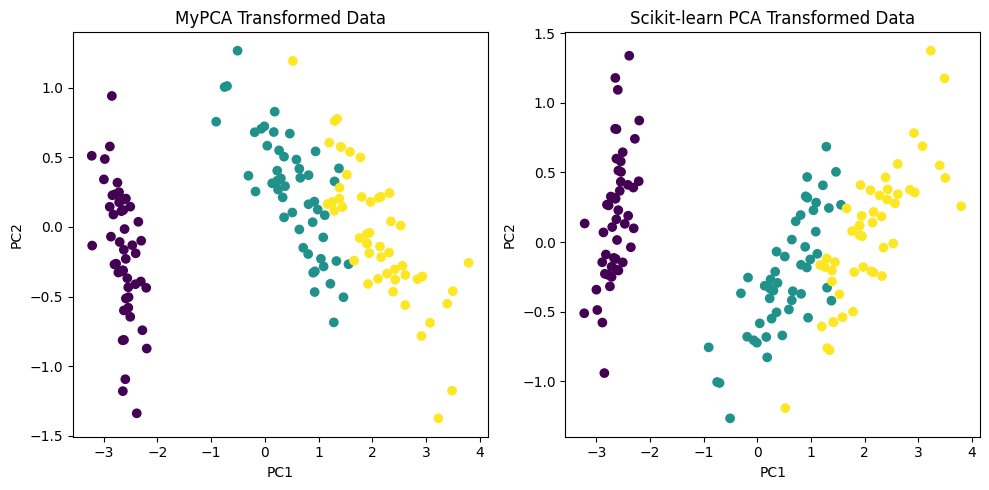

In [11]:
# Plot transformed data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_transformed_my[:, 0], X_transformed_my[:, 1], c=y_iris, cmap='viridis')
plt.title("MyPCA Transformed Data")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
plt.scatter(X_transformed_sklearn[:, 0], X_transformed_sklearn[:, 1], c=y_iris, cmap='viridis')
plt.title("Scikit-learn PCA Transformed Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [12]:
# Function to remove outliers based on feature outlier fraction
def remove_outliers_by_feature_fraction(X, y, df_original, iqr_threshold=2.0, max_outlier_features_frac=0.05):
    # This function removes rows if the fraction of outlier features exceeds max_outlier_features_frac
    # Uses IQR method to identify outliers
    print(f"\n--- Removing outliers by feature fraction (IQR threshold={iqr_threshold}, Max fraction={max_outlier_features_frac}) ---")
    # Get number of rows and features in X
    original_rows, num_features = X.shape
    # Check for empty data
    if X.size == 0 or num_features == 0:
        print("Warning: Data X is empty or has no features. Skipping outlier removal.")
        return X, y, df_original.iloc[0:0] if df_original is not None else None, np.array([], dtype=bool)
    try:
        # Check if data is numeric
        if not np.issubdtype(X.dtype, np.number):
            print("Warning: X is not numeric data. Cannot compute IQR. Skipping outlier removal.")
            return X, y, df_original, np.ones(original_rows, dtype=bool)
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = np.nanpercentile(X, 25, axis=0)
        Q3 = np.nanpercentile(X, 75, axis=0)
        # Calculate IQR
        IQR = Q3 - Q1
        # Replace NaN or zero IQR with a small value
        IQR[np.isnan(IQR)] = 1e-9
        IQR[IQR == 0] = 1e-9
    except Exception as e:
        print(f"Warning: Error computing IQR: {e}. Returning original data.")
        return X, y, df_original, np.ones(original_rows, dtype=bool)
    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - iqr_threshold * IQR
    upper_bound = Q3 + iqr_threshold * IQR
    # Identify outlier features
    is_outlier_feature = (X < lower_bound[np.newaxis, :]) | (X > upper_bound[np.newaxis, :])
    is_outlier_feature[np.isnan(X)] = False
    # Count number of outlier features per row
    num_outlier_features_per_row = np.sum(is_outlier_feature, axis=1)
    # Calculate fraction of outlier features
    fraction_outlier_features = num_outlier_features_per_row / num_features
    # Create mask to keep rows with outlier fraction below threshold
    rows_to_keep_mask = fraction_outlier_features <= max_outlier_features_frac
    # Filter data based on mask
    X_filtered = X[rows_to_keep_mask]
    y_filtered = y[rows_to_keep_mask]
    df_filtered = df_original[rows_to_keep_mask].copy()
    # Calculate number and percentage of removed rows
    rows_removed = original_rows - X_filtered.shape[0]
    removed_percentage = (rows_removed / original_rows) * 100 if original_rows > 0 else 0
    print(f"Number of rows before outlier removal: {original_rows}")
    print(f"Number of rows removed: {rows_removed} ({removed_percentage:.2f}%)")
    print(f"Number of rows after outlier removal: {X_filtered.shape[0]}")
    if X_filtered.shape[0] == 0:
        print("Warning: All rows were removed due to outlier detection!")
    return X_filtered, y_filtered, df_filtered, rows_to_keep_mask

In [13]:
# Function to load and preprocess data from CSV file
def load_and_preprocess_data(file_path, include_age=False, use_outlier_removal=True, iqr_threshold_for_outlier=2.0, max_feature_frac_for_outlier=0.05):
    # This function reads data from CSV, handles missing values, removes unnecessary columns, and removes outliers if requested
    print(f"--- Loading and preprocessing data (Outlier removal: {use_outlier_removal}) ---")
    # Read CSV file
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
        return None, None, None
    print(f"Initial number of rows: {df.shape[0]}, number of columns: {df.shape[1]}")
    # Handle missing values by filling with mean
    if df.isnull().sum().sum() > 0:
        print("Filling missing values with mean...")
        numeric_cols = df.select_dtypes(include=np.number).columns
        for col in numeric_cols:
            if not df[col].isnull().all():
                df[col].fillna(df[col].mean(), inplace=True)
            else:
                print(f"Column '{col}' contains all NaN, filling with 0.")
                df[col].fillna(0, inplace=True)
    # Define label and metadata columns
    label_col = 'group'
    metadata_base = ['site', 'subject', label_col]
    meta_exclude = metadata_base + (['age'] if not include_age else [])
    if not include_age:
        print("Removing 'age' column.")
    else:
        print("Keeping 'age' column.")
    # Select numeric feature columns
    feat_cols = [c for c in df.columns if c not in meta_exclude and pd.api.types.is_numeric_dtype(df[c])]
    if not feat_cols:
        print("Error: No numeric features found.")
        return None, None, None
    if label_col not in df.columns:
        print(f"Error: Label column '{label_col}' not found.")
        return None, None, None
    print(f"Number of initial features: {len(feat_cols)}")
    # Extract feature matrix and labels
    X_initial = df[feat_cols].values
    y_orig_labels = df[label_col].values
    # Map labels to numeric (Normal: 0, Cancer: 1)
    label_map = {'Normal': 0, 'Cancer': 1}
    y_numeric = np.array([label_map.get(l, -1) for l in y_orig_labels])
    df_current = df.copy()
    # Remove rows with invalid labels
    if np.any(y_numeric == -1):
        print("Warning: Unexpected 'group' values found. Removing these rows.")
        valid_mask = (y_numeric != -1)
        X_initial = X_initial[valid_mask]
        y_numeric = y_numeric[valid_mask]
        df_current = df_current[valid_mask].copy()
        print(f"Number of rows after removing invalid labels: {X_initial.shape[0]}")
    if X_initial is None or X_initial.shape[0] == 0:
        print("Error: Data is empty after removing invalid labels.")
        return None, None, df_current
    # Initialize processed data
    X_processed = X_initial
    y_processed = y_numeric
    df_processed = df_current.copy()
    # Remove outliers if requested
    if use_outlier_removal:
        X_processed, y_processed, df_processed, _ = remove_outliers_by_feature_fraction(
            X_initial, y_numeric, df_current,
            iqr_threshold=iqr_threshold_for_outlier,
            max_outlier_features_frac=max_feature_frac_for_outlier
        )
    else:
        print("\nSkipping outlier removal as per configuration.")
    if X_processed is None or X_processed.shape[0] == 0:
        print("Error: Data is empty after preprocessing.")
        return None, None, df_processed
    # Print label distribution
    print(f"\nLabel distribution (0:Normal, 1:Cancer) (Outlier handling: {'Processed' if use_outlier_removal else 'SKIPPED'}):")
    if y_processed.size > 0:
        u, c = np.unique(y_processed, return_counts=True)
        print(dict(zip(u, c)))
    return X_processed, y_processed, df_processed

In [14]:
# K-Means implementation class with Euclidean distance
class KMeans:
    def __init__(self, n_clusters, max_iters=200, random_state=None, n_init=100, tol=1e-6):
        # Initialize K-Means with configuration parameters
        # n_clusters: number of clusters
        self.n_clusters = n_clusters
        # max_iters: maximum iterations per run
        self.max_iters = max_iters
        # random_state: seed for reproducibility
        self.random_state = random_state
        # n_init: number of runs with different initializations
        self.n_init = n_init
        # tol: convergence threshold based on centroid change
        self.tol = tol
        # Initialize attributes to be computed during fit
        self.centroids_ = None  # Cluster centroids
        self.labels_ = None  # Cluster labels
        self.inertia_ = None  # Sum of squared distances to nearest centroid

    def _initialize_centroids_plusplus(self, X, current_seed):
        # Initialize centroids using k-means++ method
        # current_seed: random seed for current run
        rng = np.random.RandomState(current_seed)
        n_s = X.shape[0]
        # Create array to store centroids
        centroids = np.empty((self.n_clusters, X.shape[1]), dtype=X.dtype)
        if n_s == 0:
            return centroids
        # Select first centroid randomly
        centroids[0] = X[rng.randint(n_s)]
        # Select subsequent centroids based on squared distance probability
        for i in range(1, self.n_clusters):
            dist_sq = np.min([np.sum((X - c) ** 2, axis=1) for c in centroids[:i]], axis=0)
            s_d_sq = np.sum(dist_sq)
            if s_d_sq == 0:
                centroids[i] = X[rng.randint(n_s)]
                continue
            probs = dist_sq / s_d_sq
            probs = np.nan_to_num(probs)
            if probs.sum() == 0:
                centroids[i] = X[rng.randint(n_s)]
                continue
            probs /= probs.sum()
            cum_probs = np.cumsum(probs)
            r = rng.rand()
            idx = np.searchsorted(cum_probs, r, side='right')
            idx = min(idx, n_s - 1)
            centroids[i] = X[idx]
        return centroids

    def _calculate_distances_euclidean(self, X, centroids):
        # Calculate Euclidean distances from data points to centroids
        if X.shape[0] == 0:
            return np.array([]).reshape(0, centroids.shape[0])
        try:
            # Compute squared distances
            d_sq = np.sum((X[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2, axis=2)
            d_sq = np.maximum(d_sq, 0)
            # Take square root for Euclidean distance
            dist = np.sqrt(d_sq)
            return dist
        except ValueError as e:
            return np.full((X.shape[0], centroids.shape[0]), np.nan)

    def _kmeans_single_run(self, X, current_seed):
        # Perform a single K-Means run with specific centroid initialization
        if X.shape[0] < self.n_clusters:
            return np.zeros(X.shape[0], dtype=int), None, float('inf')
        # Initialize centroids
        centroids = self._initialize_centroids_plusplus(X, current_seed)
        labels = np.zeros(X.shape[0], dtype=int)
        # Iterate to update centroids and labels
        for iter_count in range(self.max_iters):
            old_c = centroids.copy()
            d_mat = self._calculate_distances_euclidean(X, centroids)
            if np.isnan(d_mat).any():
                return labels, centroids, float('inf')
            if d_mat.size == 0:
                labels = np.array([], dtype=int)
                break
            # Assign labels based on nearest distance
            new_labels = np.argmin(d_mat, axis=1)
            new_c_list = []
            empty_cluster_reinitialized = False
            # Update centroids
            for k in range(self.n_clusters):
                mask = (new_labels == k)
                if np.sum(mask) > 0:
                    new_c_list.append(X[mask].mean(axis=0))
                else:
                    new_c_list.append(X[np.random.randint(X.shape[0])])
                    empty_cluster_reinitialized = True
            new_c = np.array(new_c_list)
            if np.isnan(new_c).any():
                return labels, centroids, float('inf')
            # Calculate centroid shift
            c_shift = np.sum((new_c - old_c) ** 2)
            centroids = new_c
            # Check convergence
            if c_shift < self.tol and not empty_cluster_reinitialized:
                break
            labels = new_labels
        # Calculate inertia (sum of squared distances)
        inertia = 0.0
        if X.shape[0] > 0 and not np.isnan(centroids).any():
            try:
                inertia = np.sum([np.sum((X[labels == k] - centroids[k]) ** 2) for k in range(self.n_clusters) if np.sum(labels == k) > 0])
            except ValueError:
                inertia = float('inf')
        return labels, centroids, inertia

    def fit(self, X):
        # Train K-Means by running multiple times and selecting best result
        best_i = float('inf')
        best_l = None
        best_c = None
        if X is None or X.shape[0] < self.n_clusters:
            self.inertia_ = float('inf')
            self.labels_ = None
            self.centroids_ = None
            return self
        # Generate random seeds
        rng = np.random.RandomState(self.random_state) if isinstance(self.random_state, int) else np.random
        seeds = rng.randint(np.iinfo(np.int32).max, size=self.n_init)
        print(f"Training K-Means (distance='euclidean', n_init={self.n_init})...")
        valid_runs = 0
        for i in range(self.n_init):
            try:
                l, c, i_val = self._kmeans_single_run(X, seeds[i])
                if np.isfinite(i_val) and l is not None and c is not None:
                    valid_runs += 1
                    if i_val < best_i:
                        best_i = i_val
                        best_l = l
                        best_c = c
            except Exception as e:
                print(f"  Error in K-Means run {i+1}: {e}")
        # Handle case with no valid runs
        if best_l is None:
            print("Severe warning: K-Means could not find a valid solution.")
            self.labels_ = np.zeros(X.shape[0], dtype=int) if X.shape[0] > 0 else np.array([], dtype=int)
            self.centroids_ = self._initialize_centroids_plusplus(X, seeds[0]) if X.shape[0] >= self.n_clusters else None
            self.inertia_ = float('inf')
        else:
            self.centroids_ = best_c
            self.labels_ = best_l
            self.inertia_ = best_i
        print(f"Completed K-Means training. Valid runs: {valid_runs}/{self.n_init}. Best inertia: {self.inertia_:.2f}")
        return self

In [15]:
# Function to calculate combination (n choose 2)
def n_choose_2(n):
    # Calculate number of ways to choose 2 elements from n
    if n < 2:
        return 0
    return comb(int(n), 2)

In [16]:
# Function to calculate Adjusted Rand Index
def adjusted_rand_score_custom(labels_true, labels_pred):
    # Calculate ARI to evaluate similarity between true and predicted labels
    if not isinstance(labels_true, (np.ndarray, list)) or not isinstance(labels_pred, (np.ndarray, list)):
        return np.nan
    labels_true = np.asarray(labels_true)
    labels_pred = np.asarray(labels_pred)
    # Check label validity
    if len(labels_true) != len(labels_pred) or len(labels_true) < 2:
        return np.nan
    n_samples = len(labels_true)
    classes = np.unique(labels_true)
    clusters = np.unique(labels_pred)
    if len(clusters) < 2 or len(classes) < 2:
        return 0.0
    # Create contingency table
    contingency_table = np.zeros((len(classes), len(clusters)), dtype=int)
    for i, class_val in enumerate(classes):
        for j, cluster_val in enumerate(clusters):
            contingency_table[i, j] = np.sum((labels_true == class_val) & (labels_pred == cluster_val))
    # Calculate values needed for ARI
    sum_nij_choose_2 = sum(n_choose_2(n) for n in contingency_table.flat)
    sum_ai_choose_2 = sum(n_choose_2(n) for n in np.sum(contingency_table, axis=1))
    sum_bj_choose_2 = sum(n_choose_2(n) for n in np.sum(contingency_table, axis=0))
    N_choose_2 = n_choose_2(n_samples)
    if N_choose_2 == 0:
        return 0.0
    expected_index = (sum_ai_choose_2 * sum_bj_choose_2) / N_choose_2
    max_index = (sum_ai_choose_2 + sum_bj_choose_2) / 2.0
    denominator = max_index - expected_index
    if denominator == 0:
        return 1.0 if sum_nij_choose_2 == expected_index else 0.0
    ari = (sum_nij_choose_2 - expected_index) / denominator
    return ari

In [17]:
# Function to calculate Silhouette Score
def silhouette_score_custom(X, labels):
    # Calculate Silhouette Score to evaluate cluster quality
    if X is None or not isinstance(X, np.ndarray) or X.shape[0] < 2 or labels is None or \
       not isinstance(labels, np.ndarray) or len(np.unique(labels)) < 2 or len(labels) != X.shape[0]:
        return np.nan
    n_samples = X.shape[0]
    silhouette_vals = np.zeros(n_samples)
    unique_labels_in_data = np.unique(labels)
    if len(unique_labels_in_data) < 2:
        return np.nan
    # Calculate Silhouette value for each point
    for i in range(n_samples):
        same_cluster_mask = (labels == labels[i])
        same_cluster_points = X[same_cluster_mask & (np.arange(n_samples) != i)]
        # Calculate average distance within cluster
        if same_cluster_points.shape[0] == 0:
            a_i = 0.0
        else:
            a_i = np.mean(np.sqrt(np.sum((same_cluster_points - X[i]) ** 2, axis=1)))
        # Calculate average distance to nearest cluster
        b_i = np.inf
        for c_val in unique_labels_in_data:
            if c_val == labels[i]:
                continue
            other_cluster_mask = (labels == c_val)
            if np.sum(other_cluster_mask) == 0:
                continue
            other_cluster_points = X[other_cluster_mask]
            mean_dist_to_other_cluster = np.mean(np.sqrt(np.sum((other_cluster_points - X[i]) ** 2, axis=1)))
            b_i = min(b_i, mean_dist_to_other_cluster)
        # Calculate Silhouette for point i
        if max(a_i, b_i) == 0 or b_i == np.inf:
            silhouette_vals[i] = 0.0
        else:
            silhouette_vals[i] = (b_i - a_i) / max(a_i, b_i)
    # Return average Silhouette value
    return np.mean(silhouette_vals[np.isfinite(silhouette_vals)]) if np.any(np.isfinite(silhouette_vals)) else np.nan

In [18]:
# Function to map cluster labels to true labels
def map_clusters_to_labels(cluster_labels, true_labels):
    # Map K-Means cluster labels to true labels based on majority class
    mapping = {}
    predicted_labels = np.zeros_like(true_labels, dtype=object)
    if cluster_labels.size == 0 or true_labels.size == 0:
        return predicted_labels, mapping, None
    true_labels_series = pd.Series(true_labels)
    unique_clusters = np.unique(cluster_labels)
    unique_true_labels = np.unique(true_labels)
    positive_class_mapped_from_cluster = None
    # Handle single cluster case
    if len(unique_clusters) == 1:
        mode_true_labels = true_labels_series.mode()
        majority_true_label = mode_true_labels[0] if not mode_true_labels.empty else (unique_true_labels[0] if len(unique_true_labels) > 0 else 0)
        mapping[unique_clusters[0]] = majority_true_label
        if majority_true_label == 1:
            positive_class_mapped_from_cluster = unique_clusters[0]
    else:
        # Calculate Cancer class proportion in each cluster
        cancer_proportions = []
        for cluster_val in unique_clusters:
            mask = (cluster_labels == cluster_val)
            if np.sum(mask) == 0:
                cancer_proportions.append(0.0)
                mapping[cluster_val] = unique_true_labels[0]
                continue
            labels_in_cluster = true_labels[mask]
            cancer_count = np.sum(labels_in_cluster == 1)
            cancer_proportion = cancer_count / np.sum(mask) if np.sum(mask) > 0 else 0.0
            cancer_proportions.append(cancer_proportion)
            mode_result = pd.Series(labels_in_cluster).mode()
            mapping[cluster_val] = mode_result[0] if not mode_result.empty else unique_true_labels[0]
        # Map cluster with highest Cancer proportion to class 1
        if len(cancer_proportions) >= 2 and len(unique_clusters) >= 2:
            idx_max_cancer_prop = np.argmax(cancer_proportions)
            cluster_for_cancer = unique_clusters[idx_max_cancer_prop]
            new_mapping = {}
            for cl_val in unique_clusters:
                if cl_val == cluster_for_cancer:
                    new_mapping[cl_val] = 1
                    positive_class_mapped_from_cluster = cl_val
                else:
                    new_mapping[cl_val] = 0
            mapping = new_mapping
        elif len(unique_clusters) == 1 and len(cancer_proportions) == 1:
            map_val = 1 if cancer_proportions[0] > 0.5 else 0
            mapping[unique_clusters[0]] = map_val
            if map_val == 1:
                positive_class_mapped_from_cluster = unique_clusters[0]
    # Map cluster labels to predicted labels
    for i, cl_val in enumerate(cluster_labels):
        predicted_labels[i] = mapping.get(cl_val, unique_true_labels[0] if len(unique_true_labels) > 0 else 0)
    try:
        predicted_labels = predicted_labels.astype(true_labels.dtype)
    except ValueError:
        print("Warning: Could not convert predicted labels data type.")
    return predicted_labels, mapping, positive_class_mapped_from_cluster

In [19]:
# Function to calculate classification metrics
def calculate_classification_metrics(y_true, y_pred_mapped, positive_class_label=1):
    # Calculate TP, TN, FP, FN from true and predicted labels
    # TP: True Positive
    tp = np.sum((y_true == positive_class_label) & (y_pred_mapped == positive_class_label))
    # TN: True Negative
    tn = np.sum((y_true != positive_class_label) & (y_pred_mapped != positive_class_label))
    # FP: False Positive
    fp = np.sum((y_true != positive_class_label) & (y_pred_mapped == positive_class_label))
    # FN: False Negative
    fn = np.sum((y_true == positive_class_label) & (y_pred_mapped != positive_class_label))
    return tp, tn, fp, fn

In [20]:
# Function to evaluate clustering with full metrics
def evaluate_clustering_full_metrics(cluster_labels, true_labels, X_for_silhouette=None, positive_class_true_label=1):
    # Evaluate cluster quality using classification and clustering metrics
    metrics = {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1_score': np.nan,
               'ari': np.nan, 'silhouette': np.nan, 'mapping': {}, 'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
    if not isinstance(cluster_labels, (np.ndarray, list)) or not isinstance(true_labels, (np.ndarray, list)):
        return metrics
    if len(cluster_labels) != len(true_labels) or len(true_labels) == 0:
        return metrics
    try:
        # Map cluster labels to true labels
        predicted_labels_mapped, mapping, _ = map_clusters_to_labels(cluster_labels, true_labels)
        metrics['mapping'] = mapping
        # Calculate accuracy
        acc = np.nan
        if predicted_labels_mapped.dtype == true_labels.dtype and predicted_labels_mapped.size == true_labels.size:
            acc = np.mean(predicted_labels_mapped == true_labels)
        elif predicted_labels_mapped.size > 0 and true_labels.size > 0:
            try:
                if predicted_labels_mapped.astype(true_labels.dtype).size == true_labels.size:
                    acc = np.mean(predicted_labels_mapped.astype(true_labels.dtype) == true_labels)
            except (ValueError, TypeError):
                print("Warning: Data type mismatch, cannot compute accuracy.")
        metrics['accuracy'] = acc
        # Calculate classification metrics
        tp, tn, fp, fn = calculate_classification_metrics(true_labels, predicted_labels_mapped, positive_class_true_label)
        metrics['tp'], metrics['tn'], metrics['fp'], metrics['fn'] = tp, tn, fp, fn
        metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall']) if (metrics['precision'] + metrics['recall']) > 0 else 0.0
        # Calculate ARI and Silhouette
        metrics['ari'] = adjusted_rand_score_custom(true_labels, cluster_labels)
        if X_for_silhouette is not None and not np.any(np.isnan(X_for_silhouette)):
            metrics['silhouette'] = silhouette_score_custom(X_for_silhouette, cluster_labels)
        else:
            metrics['silhouette'] = np.nan
        print(f"Cluster to label mapping: {mapping}")
        print(f"Confusion matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
        return metrics
    except Exception as e:
        print(f"Error evaluating clusters: {e}")
        traceback.print_exc()
        return metrics

In [21]:
# Function to plot CEVR
def plot_cevr(n_components_range, cevrs):
    # Plot cumulative explained variance ratio against number of components
    valid_mask = ~np.isnan(np.array(cevrs, dtype=float))
    if not np.any(valid_mask):
        print("No valid CEVR data to plot.")
        return
    plt.figure(figsize=(10, 6))
    plt.plot(np.array(n_components_range)[valid_mask], np.array(cevrs)[valid_mask], marker='o', ls='-')
    # Plot 70% and 80% variance thresholds
    plt.axhline(y=0.7, c='r', ls='--', label='70% Var')
    plt.axhline(y=0.8, c='g', ls='--', label='80% Var')
    plt.xlabel("Number of Components")
    plt.ylabel("CEVR")
    plt.title("CEVR by Number of PCA Components")
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
# Function to plot evaluation metrics
def plot_metrics(n_components_range, accuracies, precisions, recalls, f1_scores, inertias, aris, silhouettes):
    # Plot evaluation metrics against number of components
    metrics_dict = {'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1-score': f1_scores,
                    'Inertia': inertias, 'ARI': aris, 'Silhouette': silhouettes}
    colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 'tab:green', 'tab:cyan', 'tab:brown']
    markers = ['o', 's', '^', 'd', 'x', '*', '+']
    linestyles = ['-', '-', '-', '-', '--', ':', '-.']
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax2 = ax1.twinx()
    ax_map = {'Accuracy': ax1, 'Precision': ax1, 'Recall': ax1, 'F1-score': ax1, 'Inertia': ax2, 'ARI': ax2, 'Silhouette': ax2}
    used_ax1 = False
    used_ax2 = False
    # Plot each metric
    for idx, (name, vals) in enumerate(metrics_dict.items()):
        vm = ~np.isnan(np.array(vals, dtype=float))
        if not np.any(vm):
            print(f"No valid data for {name}.")
            continue
        curr_ax = ax_map[name]
        vn = np.array(n_components_range)[vm]
        vval = np.array(vals)[vm]
        if len(vn) == 0:
            continue
        curr_ax.plot(vn, vval, marker=markers[idx], color=colors[idx], linestyle=linestyles[idx], label=name)
        if curr_ax == ax1:
            used_ax1 = True
            ax1.set_ylabel("Score (Acc, P, R, F1)", color='black')
        else:
            used_ax2 = True
            ax2.set_ylabel("Score (Inertia, ARI, Silh)", color='black')
    # Configure axes and grid
    if used_ax1:
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, axis='y', ls=':', alpha=0.7)
    if used_ax2:
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.grid(True, axis='y', ls=':', alpha=0.7, which='both')
    ax1.set_xlabel("Number of Components")
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    if lines1 and lines2:
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', ncol=2)
    elif lines1:
        ax1.legend(loc='best')
    elif lines2:
        ax2.legend(loc='best')
    fig.tight_layout()
    plt.title("Clustering Metrics by Number of PCA Components")
    plt.show()

In [23]:
# Function to plot clusters
def plot_clusters(X_pca, cluster_labels, true_labels, centroids, n_components, title_suffix=""):
    # Plot scatter plot of PCA-transformed data showing cluster and true labels
    if X_pca is None or X_pca.shape[1] < 2:
        print("Cannot plot: Insufficient PCA components.")
        return
    if not isinstance(cluster_labels, (np.ndarray, list)) or not isinstance(true_labels, (np.ndarray, list)) or len(cluster_labels) != len(true_labels):
        print("Cannot plot: Invalid labels.")
        return
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    try:
        # Plot cluster labels
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', legend='full', alpha=0.7)
        if centroids is not None and centroids.shape[0] > 0 and centroids.shape[1] >= 2:
            plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=150, label='Centroids', edgecolors='black')
        plt.title(f"K-Means Clusters (n={n_components}){title_suffix}")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        plt.grid(True)
    except Exception as e:
        print(f"Error plotting cluster labels: {e}")
    plt.subplot(1, 2, 2)
    try:
        # Plot true labels
        true_labels_plot = pd.Series(true_labels).astype(str)
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=true_labels_plot, palette='coolwarm', legend='full', alpha=0.7)
        plt.title(f"True Labels (on first two PCs){title_suffix}")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        plt.grid(True)
    except Exception as e:
        print(f"Error plotting true labels: {e}")
    plt.tight_layout()
    plt.show()

In [24]:
# Main program logic
start_run_time = time.time()

In [25]:
# Load and preprocess ABIDE II data
file_path = "ABIDE2.csv"
X, y, df = load_and_preprocess_data(file_path,
                                    include_age=False,
                                    use_outlier_removal=True,
                                    iqr_threshold_for_outlier=2.5,
                                    max_feature_frac_for_outlier=0.05)

if X is None or y is None:
    print("Exiting program.")
    exit()

--- Loading and preprocessing data (Outlier removal: True) ---
Initial number of rows: 1004, number of columns: 1445
Removing 'age' column.
Number of initial features: 1441

--- Removing outliers by feature fraction (IQR threshold=2.5, Max fraction=0.05) ---
Number of rows before outlier removal: 1004
Number of rows removed: 3 (0.30%)
Number of rows after outlier removal: 1001

Label distribution (0:Normal, 1:Cancer) (Outlier handling: Processed):
{np.int64(0): np.int64(540), np.int64(1): np.int64(461)}


In [26]:
# Precompute PCA for maximum number of components
print("\n--- Precomputing PCA for maximum number of components ---")
max_pc_for_precompute = min(X.shape[1], 250)
if X.shape[1] == 0:
    print("Error: X has no features. Cannot perform PCA.")
    exit()
pca_temp = MyPCA(n_components=max_pc_for_precompute)
X, _, _ = standardize(X)  # Use standardize function for Z-score standardization
pca_temp.fit(X)
cevrs_full_range = pca_temp.cumulative_explained_variance_ratio_ if hasattr(pca_temp, 'cumulative_explained_variance_ratio_') and pca_temp.cumulative_explained_variance_ratio_ is not None else np.array([])
# Determine number of components for 70% and 80% variance
n_for_70_cevr = np.argmax(cevrs_full_range >= 0.70) + 1 if np.any(cevrs_full_range >= 0.70) else max_pc_for_precompute
n_for_80_cevr = np.argmax(cevrs_full_range >= 0.80) + 1 if np.any(cevrs_full_range >= 0.80) else max_pc_for_precompute
# Create list of components to test
n_comp_values = [10, 20, 30, 50]
if n_for_70_cevr not in n_comp_values and n_for_70_cevr <= max_pc_for_precompute:
    n_comp_values.append(int(round(n_for_70_cevr)))
if n_for_80_cevr not in n_comp_values and n_for_80_cevr <= max_pc_for_precompute:
    n_comp_values.append(int(round(n_for_80_cevr)))
for val in [100, 150, 200, 250]:
    if val <= max_pc_for_precompute and val not in n_comp_values:
        n_comp_values.append(val)
n_components_range = sorted(list(set(n_comp_values)))
n_components_range = [n_val for n_val in n_components_range if n_val <= max_pc_for_precompute and n_val > 0]
if not n_components_range:
    n_components_range = [min(10, max_pc_for_precompute)] if max_pc_for_precompute > 0 else [1]
print(f"Testing PCA component counts: {n_components_range}")


--- Precomputing PCA for maximum number of components ---
Testing PCA component counts: [10, 20, 30, 50, 69, 100, 126, 150, 200, 250]


In [27]:
# Set K-Means parameters
kmeans_n_init = 100
kmeans_max_iters = 200
kmeans_random_state = 42
results = []
# Experiment with different numbers of principal components
for n in n_components_range:
    loop_start_time = time.time()
    print(f"\n--- Experimenting with n_components = {n} ---")
    eval_metrics = {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1_score': np.nan,
                    'ari': np.nan, 'silhouette': np.nan, 'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
    inertia_val = np.nan
    current_cevr = np.nan
    x_pca_current = None
    try:
        # Initialize and train PCA
        pca = MyPCA(n_components=n)
        pca.fit(X)
        current_cevr = pca.cumulative_explained_variance_ratio_[-1]
        print(f"  CEVR: {current_cevr:.4f}")
        # Transform data
        x_pca_current = pca.transform(X)
        x_pca_current_std, _, _ = standardize(x_pca_current)
        if np.any(np.isnan(x_pca_current_std)) or np.any(np.isinf(x_pca_current_std)):
            raise ValueError("Standardized PCA data contains NaN or Inf")
        print(f"  Standardized PCA data shape: {x_pca_current_std.shape}")
        # Train K-Means
        kmeans = KMeans(n_clusters=2, max_iters=kmeans_max_iters, random_state=kmeans_random_state, n_init=kmeans_n_init)
        kmeans.fit(x_pca_current_std)
        if kmeans.labels_ is not None and len(kmeans.labels_) == len(y) and len(y) > 0:
            eval_metrics = evaluate_clustering_full_metrics(kmeans.labels_, y, x_pca_current_std, positive_class_true_label=1)
            inertia_val = kmeans.inertia_ if kmeans.inertia_ is not None else np.nan
        else:
            print("  Warning: K-Means failed to produce valid labels or y is empty.")
    except Exception as e:
        print(f"Error for n={n}: {e}")
        traceback.print_exc()
    loop_end_time = time.time()
    run_time = loop_end_time - loop_start_time
    results.append({'n': n, **eval_metrics, 'inertia': inertia_val, 'cevr': current_cevr, 'time': run_time})
    # Print results
    print(f"  Accuracy: {eval_metrics['accuracy']:.4f}" if not np.isnan(eval_metrics['accuracy']) else "N/A")
    print(f"  Precision: {eval_metrics['precision']:.4f}" if not np.isnan(eval_metrics['precision']) else "N/A")
    print(f"  Recall: {eval_metrics['recall']:.4f}" if not np.isnan(eval_metrics['recall']) else "N/A")
    print(f"  F1-score: {eval_metrics['f1_score']:.4f}" if not np.isnan(eval_metrics['f1_score']) else "N/A")
    print(f"  ARI: {eval_metrics['ari']:.4f}" if not np.isnan(eval_metrics['ari']) else "N/A")
    print(f"  Silhouette: {eval_metrics['silhouette']:.4f}" if not np.isnan(eval_metrics['silhouette']) else "N/A")
    print(f"  Inertia: {inertia_val:.2f}" if not np.isnan(inertia_val) else "N/A")
    print(f"  Time: {run_time:.2f}s")


--- Experimenting with n_components = 10 ---
  CEVR: 0.4560
  Standardized PCA data shape: (1001, 10)
Training K-Means (distance='euclidean', n_init=100)...
Completed K-Means training. Valid runs: 100/100. Best inertia: 9297.85
Cluster to label mapping: {np.int64(0): 0, np.int64(1): 1}
Confusion matrix: TP=185, TN=358, FP=182, FN=276
  Accuracy: 0.5425
  Precision: 0.5041
  Recall: 0.4013
  F1-score: 0.4469
  ARI: 0.0059
  Silhouette: 0.0852
  Inertia: 9297.85
  Time: 1.53s

--- Experimenting with n_components = 20 ---
  CEVR: 0.5246
  Standardized PCA data shape: (1001, 20)
Training K-Means (distance='euclidean', n_init=100)...
Completed K-Means training. Valid runs: 100/100. Best inertia: 19300.59
Cluster to label mapping: {np.int64(0): 1, np.int64(1): 0}
Confusion matrix: TP=340, TN=215, FP=325, FN=121
  Accuracy: 0.5544
  Precision: 0.5113
  Recall: 0.7375
  F1-score: 0.6039
  ARI: 0.0103
  Silhouette: 0.0419
  Inertia: 19300.59
  Time: 2.51s

--- Experimenting with n_components =


--- Summary of experimental results (Controlled outlier removal, Age excluded, K-Means Euclidean) ---
K-Means configuration: n_init=100, max_iters=200
Best accuracy (0.5544) @ n_components = 20


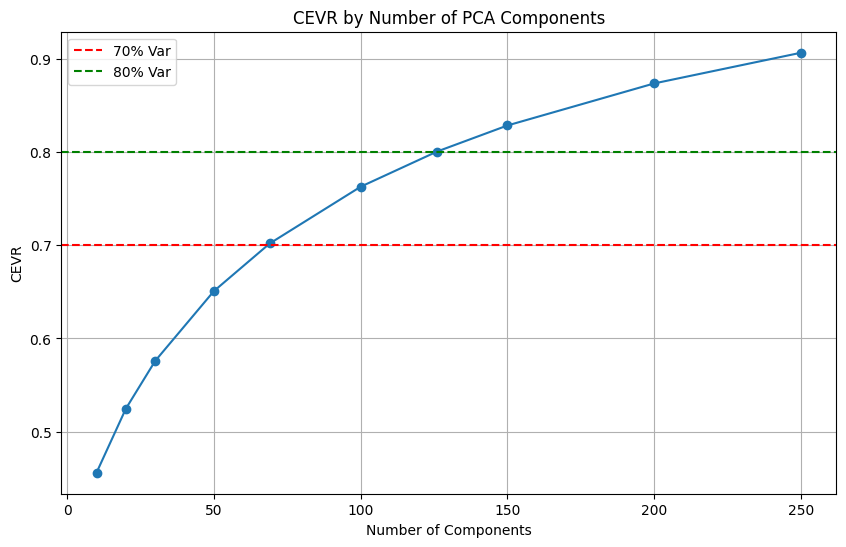

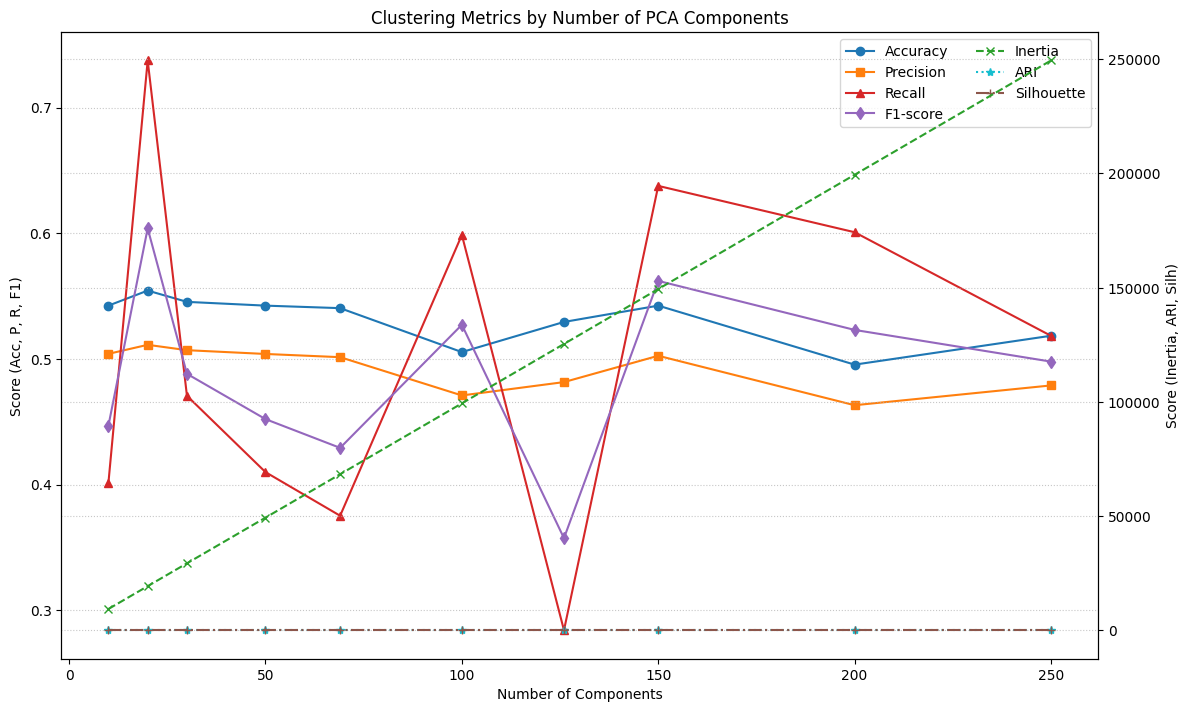

In [28]:
# Create DataFrame from results
results_df = pd.DataFrame(results)
valid_results_df = results_df.dropna(subset=['accuracy'])
optimal_n = None
best_metrics = {k: np.nan for k in ['accuracy', 'precision', 'recall', 'f1_score', 'ari', 'silhouette', 'tp', 'tn', 'fp', 'fn']}
optimal_cevr = np.nan
optimal_inertia = np.nan
# Select optimal number of components based on accuracy
if valid_results_df.empty:
    print("\nSevere error: No valid accuracy results obtained.")
else:
    best_result_row = valid_results_df.loc[valid_results_df['accuracy'].idxmax()]
    optimal_n = int(best_result_row['n'])
    best_metrics = {k: best_result_row.get(k, np.nan) for k in best_metrics.keys()}
    optimal_cevr = best_result_row.get('cevr', np.nan)
    optimal_inertia = best_result_row.get('inertia', np.nan)
    print("\n--- Summary of experimental results (Controlled outlier removal, Age excluded, K-Means Euclidean) ---")
    print(f"K-Means configuration: n_init={kmeans_n_init}, max_iters={kmeans_max_iters}")
    print(f"Best accuracy ({best_metrics['accuracy']:.4f}) @ n_components = {optimal_n}")
    # Plot results
    if not valid_results_df.empty:
        plot_cevr(valid_results_df['n'].tolist(), valid_results_df['cevr'].tolist())
        plot_metrics(valid_results_df['n'].tolist(), valid_results_df['accuracy'].tolist(),
                     valid_results_df['precision'].tolist(), valid_results_df['recall'].tolist(),
                     valid_results_df['f1_score'].tolist(), valid_results_df['inertia'].tolist(),
                     valid_results_df['ari'].tolist(), valid_results_df['silhouette'].tolist())


--- Running final model with optimal n_components = 20 ---
Training K-Means (distance='euclidean', n_init=100)...
Completed K-Means training. Valid runs: 100/100. Best inertia: 19300.59
Cluster to label mapping: {np.int64(0): 1, np.int64(1): 0}
Confusion matrix: TP=340, TN=215, FP=325, FN=121

--- Final model evaluation (Controlled outlier removal, Age excluded, K-Means Euclidean) ---
Optimal number of components: 20
K-Means: n_init=100, max_iters=200
Final Accuracy: 0.5544
Final Precision: 0.5113
Final Recall: 0.7375
Final F1_score: 0.6039
Final Ari: 0.0103
Final Silhouette: 0.0419
Final confusion matrix: TP=340, TN=215, FP=325, FN=121
Final inertia: 19300.59
Final model runtime: 2.64s


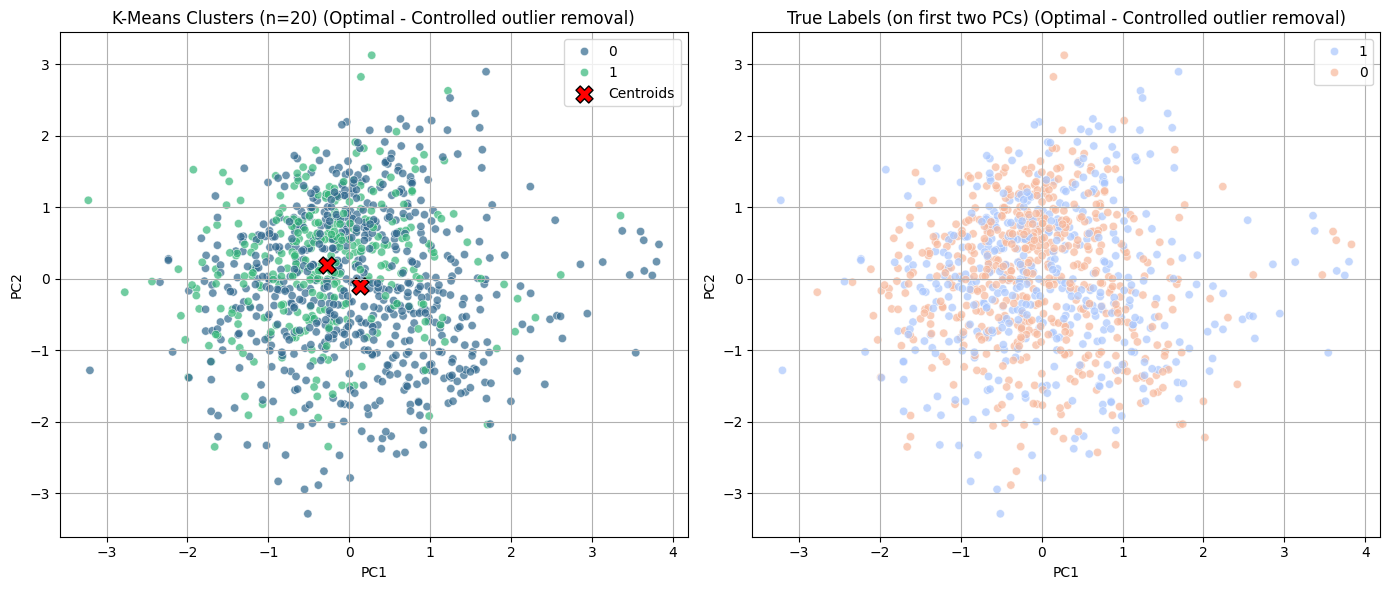

In [29]:
# Run final model with optimal number of components
if optimal_n is not None:
    print(f"\n--- Running final model with optimal n_components = {optimal_n} ---")
    final_start_time = time.time()
    try:
        pca_final = MyPCA(n_components=optimal_n)
        pca_final.fit(X)
        X_pca_final = pca_final.transform(X)
        X_pca_final_std, _, _ = standardize(X_pca_final)
        kmeans_final = KMeans(n_clusters=2, max_iters=kmeans_max_iters, random_state=kmeans_random_state, n_init=kmeans_n_init)
        kmeans_final.fit(X_pca_final_std)
        final_end_time = time.time()
        if kmeans_final.labels_ is not None and len(kmeans_final.labels_) == len(y):
            final_eval_metrics = evaluate_clustering_full_metrics(kmeans_final.labels_, y, X_pca_final_std, positive_class_true_label=1)
            final_inertia = kmeans_final.inertia_
        else:
            final_eval_metrics = {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1_score': np.nan,
                                  'ari': np.nan, 'silhouette': np.nan, 'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
            final_inertia = np.nan
        print("\n--- Final model evaluation (Controlled outlier removal, Age excluded, K-Means Euclidean) ---")
        print(f"Optimal number of components: {optimal_n}")
        print(f"K-Means: n_init={kmeans_n_init}, max_iters={kmeans_max_iters}")
        for metric_name, metric_val in final_eval_metrics.items():
            if metric_name not in ['mapping', 'tp', 'tn', 'fp', 'fn']:
                print(f"Final {metric_name.capitalize()}: {metric_val:.4f}" if not np.isnan(metric_val) else f"Final {metric_name.capitalize()}: N/A")
        print(f"Final confusion matrix: TP={final_eval_metrics['tp']}, TN={final_eval_metrics['tn']}, FP={final_eval_metrics['fp']}, FN={final_eval_metrics['fn']}")
        print(f"Final inertia: {final_inertia:.2f}" if not np.isnan(final_inertia) else "N/A")
        print(f"Final model runtime: {final_end_time - final_start_time:.2f}s")
        if not np.isnan(final_eval_metrics['accuracy']):
            plot_clusters(X_pca_final_std, kmeans_final.labels_, y, kmeans_final.centroids_, optimal_n, title_suffix=" (Optimal - Controlled outlier removal)")
    except Exception as e:
        print(f"Error running final model: {e}")
        traceback.print_exc()
else:
    print("\nSkipping final model run: optimal n_components not determined.")